In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedGroupKFold

In [2]:
def convert_data(df):
    tmp = {}
    other = {}
    ll = df["target_name"].unique().tolist()
    for i in df[["image_path", "target_name", "target", "Species", "State", "Sampling_Date"]].values:
        if i[0] not in tmp:
            tmp[i[0]] = [None for _ in range(len(ll))]
        other[i[0]] = {"Species": i[3], "State": i[4], "Sampling_Date": i[5]}
        tmp[i[0]][ll.index(i[1])] = i[2]
    new_data = []
    for k, v in tmp.items():
        new_data.append({
            "id": k,
            **dict(zip(ll, v)),
            **other[k]
        })
    new_data = pd.DataFrame(new_data)
    return new_data

In [4]:
df = pd.read_csv("./datasets/train.csv")
df = convert_data(df)
df.to_csv("./datasets/train_full.csv", index=False)
df

,id,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g,Species,State,Sampling_Date
0,train/ID1011485656.jpg,0.0000,31.9984,16.2751,48.2735,16.2750,Ryegrass_Clover,Tas,2015/9/4
1,train/ID1012260530.jpg,0.0000,0.0000,7.6000,7.6000,7.6000,Lucerne,NSW,2015/4/1
2,train/ID1025234388.jpg,6.0500,0.0000,0.0000,6.0500,6.0500,SubcloverDalkeith,WA,2015/9/1
3,train/ID1028611175.jpg,0.0000,30.9703,24.2376,55.2079,24.2376,Ryegrass,Tas,2015/5/18
4,train/ID1035947949.jpg,0.4343,23.2239,10.5261,34.1844,10.9605,Ryegrass,Tas,2015/9/11
...,...,...,...,...,...,...,...,...,...
352,train/ID975115267.jpg,40.0300,0.0000,0.8000,40.8300,40.8300,Clover,WA,2015/7/8
353,train/ID978026131.jpg,24.6445,4.1948,12.0601,40.8994,36.7046,Clover,Tas,2015/9/4
354,train/ID980538882.jpg,0.0000,1.1457,91.6543,92.8000,91.6543,Phalaris,NSW,2015/2/24
355,train/ID980878870.jpg,32.3575,0.0000,2.0325,34.3900,34.3900,Clover,WA,2015/7/8


<Axes: xlabel='Dry_Total_g', ylabel='Count'>

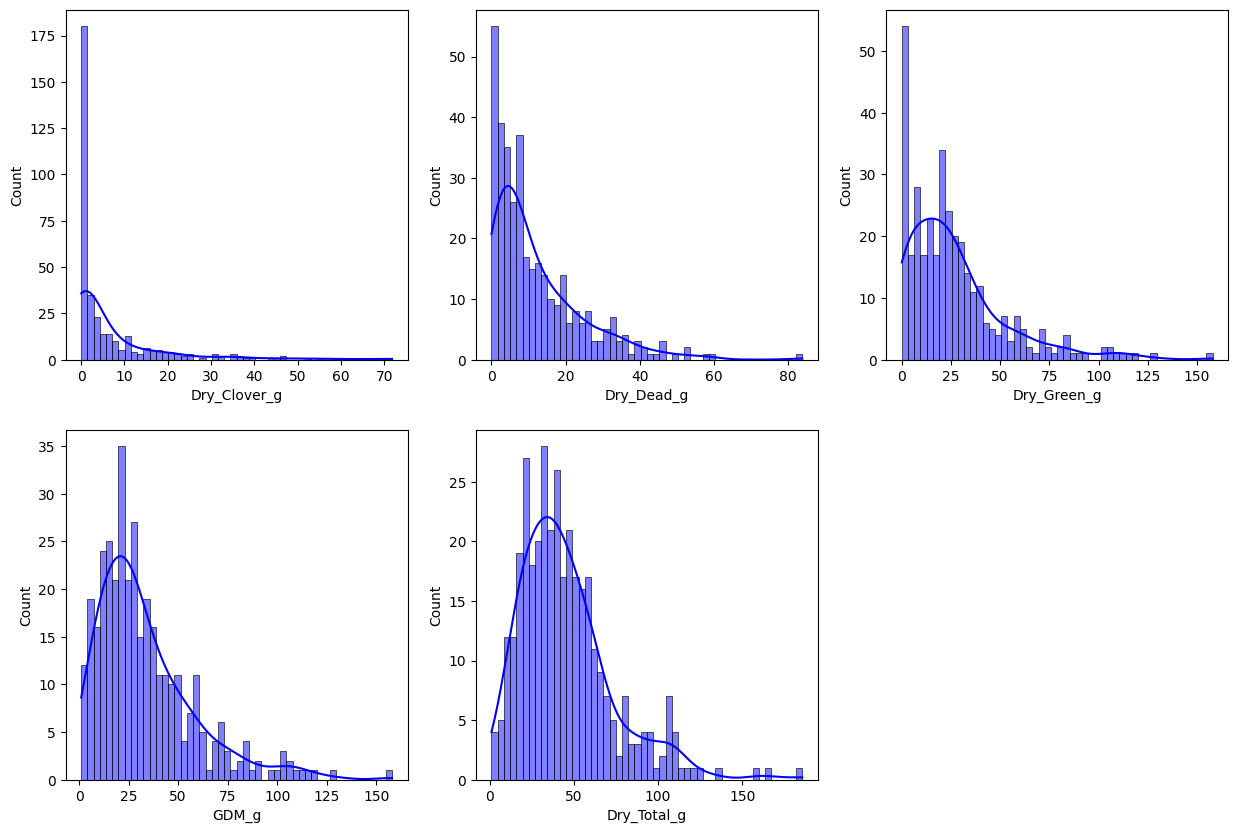

In [5]:
plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
sns.histplot(data=df, x="Dry_Clover_g", kde=True, bins=50, color='Blue')
plt.subplot(2,3,2)
sns.histplot(data=df, x="Dry_Dead_g", kde=True, bins=50, color='Blue')
plt.subplot(2,3,3)
sns.histplot(data=df, x="Dry_Green_g", kde=True, bins=50, color='Blue')
plt.subplot(2,3,4)
sns.histplot(data=df, x="GDM_g", kde=True, bins=50, color='Blue')
plt.subplot(2,3,5)
sns.histplot(data=df, x="Dry_Total_g", kde=True, bins=50, color='Blue')

In [6]:
def optimal_sampling_strategy(df, n_splits=5, random_state=1104):
    df = df.copy()
    df['bio_bin'] = pd.qcut(df['Dry_Total_g'], q=4, labels=['Low', 'Med', 'High', 'VeryHigh'])
    df['stratify_key'] = df['Species'].astype(str) + "_" + df['bio_bin'].astype(str)
    counts = df['stratify_key'].value_counts()
    rare_labels = counts[counts < n_splits].index
    df.loc[df['stratify_key'].isin(rare_labels), 'stratify_key'] = 'Rare_Combo'
    groups = df['Sampling_Date'] 
    y = df['State']
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    df['fold'] = -1
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(df, y, groups=groups)):
        df.loc[val_idx, 'fold'] = fold
    return df

def check_effectiveness(df):
    print(f"Total sample: {len(df)}")
    print("-" * 30)
    for f in range(df["fold"].max()+1):
        val = df[df['fold'] == f]
        train = df[df['fold'] != f]
        val_dates = set(val['Sampling_Date'].unique())
        train_dates = set(train['Sampling_Date'].unique())
        intersect = val_dates.intersection(train_dates)
        is_leaked = len(intersect) > 0
        train_mean = train[['Dry_Green_g','Dry_Dead_g','Dry_Clover_g','GDM_g','Dry_Total_g']].mean()
        val_mean = val[['Dry_Green_g','Dry_Dead_g','Dry_Clover_g','GDM_g','Dry_Total_g']].mean()
        n_species = val['Species'].nunique()
        print(f"Fold {f}:")
        print(f"  - Number of images: {len(val)} (Train: {len(train)})")
        print(f"  - Date Leak: {is_leaked} (Dates in Val: {len(val_dates)})")
        print(f"  - Mean Biomass: Val=\n{val_mean} vs Train=\n{train_mean}")
        print(f"  - Species Coverage: {n_species}/15 species")
        
def find_best_seed_brute_force(df, n_splits=4, search_range=2000):
    df = df.copy()
    df['bio_bin'] = pd.qcut(df['Dry_Total_g'], q=4, labels=['Low', 'Med', 'High', 'VeryHigh'])
    df['stratify_key'] = df['Species'].astype(str) + "_" + df['bio_bin'].astype(str)
    cnt = df['stratify_key'].value_counts()
    rare_labels = cnt[cnt < n_splits].index
    df.loc[df['stratify_key'].isin(rare_labels), 'stratify_key'] = 'Rare'
    global_mean = df['Dry_Total_g'].mean()
    global_std = df['Dry_Total_g'].std()
    best_seed = -1
    best_score = float('inf')
    print(f"Scanning for the best seed to optimize 4-Fold splitting...")
    for seed in tqdm(range(search_range)):
        sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
        fold_stats = []
        valid_split = True
        splits = list(sgkf.split(df, df['State'], groups=df['Sampling_Date']))
        if len(splits) < n_splits:
            continue
        current_seed_penalty = 0
        for train_idx, val_idx in splits:
            val_df = df.iloc[val_idx]
            mean_diff = abs(val_df['Dry_Total_g'].mean() - global_mean)
            std_diff = abs(val_df['Dry_Total_g'].std() - global_std)
            size_diff = abs(len(val_df) - (len(df)/n_splits))
            penalty = (mean_diff * 1.0) + (std_diff * 0.5) + (size_diff * 0.1)
            current_seed_penalty += penalty
        avg_penalty = current_seed_penalty / n_splits
        if avg_penalty < best_score:
            best_score = avg_penalty
            best_seed = seed
    print(f"\n🏆 Found Best Seed: {best_seed}")
    print(f"📉 Penalty Score: {best_score:.4f} (Closer to 0 is better)")
    return best_seed

In [7]:
find_best_seed_brute_force(df, 5, 20000)

Scanning for the best seed to optimize 4-Fold splitting...


100%|██████████| 20000/20000 [01:25<00:00, 233.97it/s]


🏆 Found Best Seed: 16999
📉 Penalty Score: 2.4313 (Closer to 0 is better)


16999

In [8]:
folds = optimal_sampling_strategy(df, n_splits=5, random_state=16999)
check_effectiveness(folds)

Total sample: 357
------------------------------
Fold 0:
  - Number of images: 69 (Train: 288)
  - Date Leak: False (Dates in Val: 6)
  - Mean Biomass: Val=
Dry_Green_g     23.763107
Dry_Dead_g      13.267399
Dry_Clover_g     7.299284
GDM_g           31.062401
Dry_Total_g     44.329796
dtype: float64 vs Train=
Dry_Green_g     27.310318
Dry_Dead_g      11.751573
Dry_Clover_g     6.494061
GDM_g           33.804375
Dry_Total_g     45.554877
dtype: float64
  - Species Coverage: 7/15 species
Fold 1:
  - Number of images: 52 (Train: 305)
  - Date Leak: False (Dates in Val: 4)
  - Mean Biomass: Val=
Dry_Green_g     19.836785
Dry_Dead_g      14.261015
Dry_Clover_g    12.682923
GDM_g           32.519708
Dry_Total_g     46.780729
dtype: float64 vs Train=
Dry_Green_g     27.782010
Dry_Dead_g      11.666658
Dry_Clover_g     5.621076
GDM_g           33.403085
Dry_Total_g     45.068730
dtype: float64
  - Species Coverage: 7/15 species
Fold 2:
  - Number of images: 69 (Train: 288)
  - Date Leak: Fals

In [9]:
!mkdir ./datasets/fold_news1

In [ ]:
for i in range(5):
    fold_df = folds.copy()
    fold_df['split'] = 'train'
    fold_df.loc[fold_df['fold'] == i, 'split'] = 'valid'
    fold_df.to_csv(f"./datasets/fold_news1/fold_{i}.csv", index=False)